## Basics

In [1]:
from primitives import Parameters
p = Parameters()
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)
(cc_J,cc_W,cc_Wstar,cc_Jpi)=cc.J()

Z_grid: [0.38006174 0.65003615 1.         1.53837598 2.63115146]
(100,)


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\search.py:155: RuntimeWarning: invalid value encountered in power
  self.e0 = -np.power(-self.x[0]/self.x[1], 1/self.x[2]) + self.e_asy #Andrei: This is the crossing point of the function, where p(v) = 0.


AssertionError: asymptote point is not larger than 0 crossing

In [2]:
#%%timeit
from Multiworker_Contract import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p)
(mwc_J,mwc_W,mwc_Wstar)=mwc.J()

(100,)
Ji shape (3, 6, 6, 100)
W1i shape (3, 6, 6, 100, 2)


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  self.rsqr[iz, in0, in1] = res2.fun / np.power(J1[iz, in0, in1, :],2).mean()


Value diff: 944.218318534955
Worker Value diff: 188.43596104942444
Errors: nan 8.97933353225516 nan 0.061858121417449556 1
(100,)


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:169: RuntimeWarning: invalid value encountered in scalar divide
  self.gamma_all[iz, in0, in1, 1] = ( (Xi-xbar) * (Yi-ybar) * W ).sum() / (  (Xi-xbar) * (Xi-ybar) * W ).sum()
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:166: RuntimeWarning: invalid value encountered in divide
  W = W / W.sum()


Value diff: 1004.4808105733688
Worker Value diff: 155.6213758748393
Errors: nan 14.815621605561144 nan 0.045810221036949705 0.04933146367966598
Value diff: 742.200752841266
Worker Value diff: 89.97508194847006
Errors: nan 6.6503096498027245 nan 0.011324678524480502 0.04933146367966598
Value diff: 576.2592514530361
Worker Value diff: 68.24187943885678
Errors: nan 3.9276724348427154 nan 0.0030714168148088645 0.04933146367966598
Value diff: 446.15029805835917
Worker Value diff: 60.962426588266254
Errors: nan 2.3530919422667522 nan 0.0009524351710923702 0.04933146367966598
Value diff: 367.24421944763935
Worker Value diff: 51.00961405341417
Errors: nan 1.789787478232329 nan 0.0004274999397160189 0.04933146367966598
Value diff: 324.11145349875005
Worker Value diff: 46.135778664254474
Errors: nan 0.9329247918699024 nan 0.0003179321130367772 0.04933146367966598
Value diff: 285.80209918140554
Worker Value diff: 41.178609544049465
Errors: nan 0.35474713362371696 nan 0.0002987908059577764 0.04933

In [ ]:
J_deriv=    np.zeros_like(mwc_J)
            # First boundary condition: forward difference
J_deriv[:, :, 0, :] = mwc_J[:, :, 1, :] - mwc_J[:, :, 0, :]
            #print("1st part", Jderiv1)

            # Last boundary condition: backward difference
J_deriv[:, :, -1, :] = mwc_J[:, :, -1, :] - mwc_J[:, :, -2, :]
            #print("2nd part", Jderiv1)

            # Central differences: average of forward and backward differences
J_deriv[:, :, 1:-1, :] = (mwc_J[:, :, 2:, :] - mwc_J[:, :, 1:-1, :] + mwc_J[:, :, 1:-1, :] - mwc_J[:, :, :-2, :]) / 2

In [5]:
mwc.w_grid[99]*(mwc.sum_size[0,0,10,10,0,0])
#mwc.sum_wage[0,10,10,10,99,99] 
#Same value of maximum wage at all the maximum sizes. Keep in mind that this ignores the wage and size at the very first step.

1010.9748841899266

# Plots

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

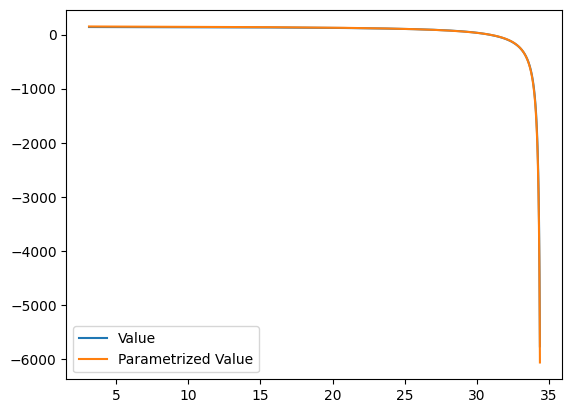

In [ ]:
plt.plot(cc_W[p.z_0-1, :], cc_J[p.z_0-1, :], label='CRS')
plt.plot(mwc_W[p.z_0-1, 0, 1, :], J_deriv[p.z_0-1, 0, 1, :], label='DRS derivative at size 1')
plt.legend()
plt.show()

Text(0, 0.5, 'Future value')

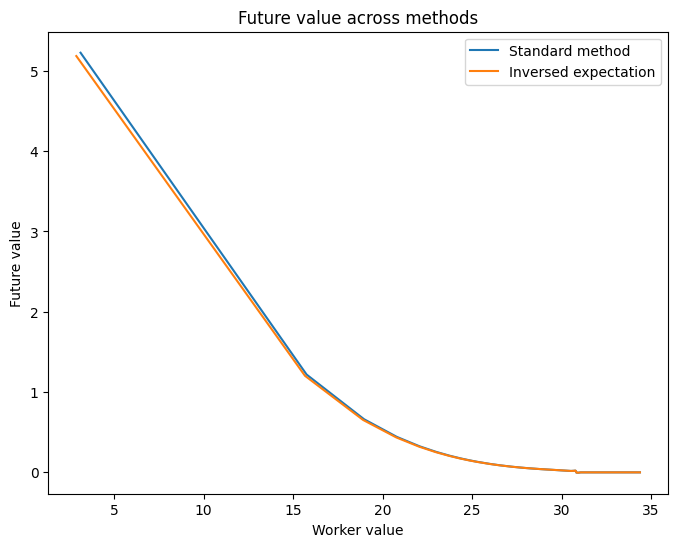

In [ ]:
plt.figure(figsize=(8, 6))  # Width=16 inches, Height=12 inches

# Plot the data
plt.plot(cc_W[p.z_0-1, :], cc_Wstar[p.z_0-1, :]-cc_W[p.z_0-1, :], label='Standard method')
plt.plot(mwc_W[p.z_0-1, 0, 1,:], mwc_Wstar[p.z_0-1, 0, 1, :]-mwc_W[p.z_0-1, 0, 1,:], label='Inversed expectation')
plt.legend()
# Add titles and labels
plt.title('Future value across methods')
plt.xlabel('Worker value')
plt.ylabel('Future value')

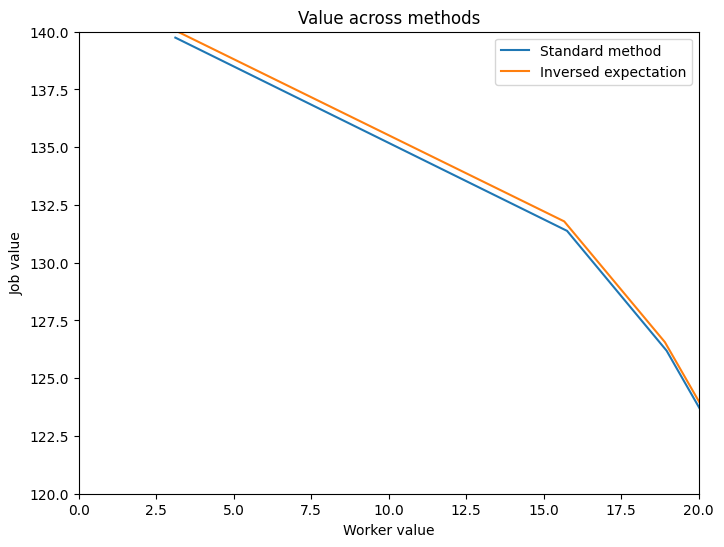

In [ ]:
# Create a figure with a specific size
plt.figure(figsize=(8, 6))  # Width=16 inches, Height=12 inches

# Plot the data
plt.plot(cc_W[p.z_0-1, :], cc_J[p.z_0-1, :], label='Standard method')
plt.plot(mwc_W[p.z_0-1, 0, 1,:], J_deriv[p.z_0-1, 0, 1, :], label='Inversed expectation')

# Add titles and labels
plt.title('Value across methods')
plt.xlabel('Worker value')
plt.ylabel('Job value')

# Optionally set x and y limits
# plt.xlim([-30, 30])
# plt.ylim([150, 200])

# Add legend
plt.legend()

# Save the plot to a file in the specified directory
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Value across methods.png'), bbox_inches='tight')  # Save as PNG


# Optionally set x and y limits
plt.xlim([0, 20])
plt.ylim([120, 140])
# Save the plot to a file
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Value across methods zoom.png'), bbox_inches='tight')  # Save as PNG

# Show the plot (optional)
plt.show()

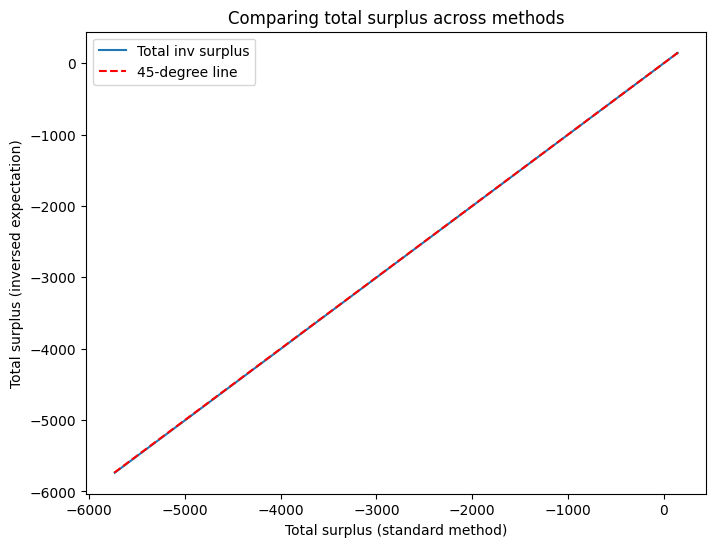

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))#This creates a figure and a set of subplots with a specific size. The size is specified in inches (width, height).

# Plot the original data
ax.plot(cc_W[p.z_0-1,:]+cc_J[p.z_0-1,:], mwc_W[p.z_0-1, 0, 1,:]+J_deriv[p.z_0-1, 0, 1, :], label='Total inv surplus')

# Calculate the range for the 45-degree line
x_vals = cc_W[p.z_0-1,:] + cc_J[p.z_0-1,:]
y_vals = mwc_W[p.z_0-1, 0, 1,:] + J_deriv[p.z_0-1, 0, 1, :]
min_val = min(min(x_vals), min(y_vals))
max_val = max(max(x_vals), max(y_vals))

# Add the 45-degree line
ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='45-degree line')

# Add titles and labels
ax.set_title('Comparing total surplus across methods')
ax.set_xlabel('Total surplus (standard method)')
ax.set_ylabel('Total surplus (inversed expectation)')
ax.legend()

# Save the plot to a file
save=0
if save==1:
    plt.savefig(os.path.join(output_dir,'Total surplus comparison.png'), bbox_inches='tight')  # Save as PNG
#    plt.savefig(os.path.join(output_dir,'Total surplus comparison.pdf'), bbox_inches='tight')  # Save as PDF

# Show the plot
plt.show()